# Problem Statement

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

import pandas as pd
import pathlib
from pathlib import Path

import numpy as np
import pandas as pd

# plotting modules
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import plotly as plotly
plotly.offline.init_notebook_mode()

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import load_model

import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, ConfusionMatrixDisplay

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
# data_folder = pathlib.Path("../../../../../Downloads/archive/plantnet_300K")

data_folder = pathlib.Path("./data-collection")

In [6]:
train_path = data_folder / "images_train"
val_path = data_folder / "images_val"
test_path = data_folder / "images_test"

In [7]:
plant_folders = [x for x in train_path.glob('*') if x.is_dir()]
plant_folders = [x.name for x in plant_folders]
plant_folders[:10]

['1643690',
 '1398830',
 '1359525',
 '1419173',
 '1394498',
 '1358690',
 '1409705',
 '1366899',
 '1391113',
 '1367949']

In [8]:
len(plant_folders)

1081

In [9]:
# how many images are in each folder
plant_count = {}
for plant in plant_folders:
    plant_count[plant] = len(list(train_path.glob(f'{plant}/*')))
    
plant_count = {k: v for k, v in sorted(plant_count.items(), key=lambda item: item[1], reverse=True)}
plant_count

{'1363227': 7208,
 '1392475': 6337,
 '1356022': 6140,
 '1364099': 5334,
 '1355937': 5178,
 '1359517': 5063,
 '1357330': 4837,
 '1358752': 4502,
 '1359620': 4285,
 '1363128': 4005,
 '1363991': 3862,
 '1355936': 3419,
 '1394460': 3388,
 '1363740': 3353,
 '1394994': 3183,
 '1364173': 3031,
 '1359616': 2811,
 '1364164': 2788,
 '1361824': 2739,
 '1361823': 2738,
 '1397364': 2700,
 '1358095': 2468,
 '1363130': 2448,
 '1389510': 2385,
 '1374048': 2330,
 '1367432': 2245,
 '1409238': 2241,
 '1397268': 2200,
 '1393614': 2101,
 '1356781': 2007,
 '1369887': 1952,
 '1393241': 1941,
 '1394420': 1899,
 '1398178': 1779,
 '1408774': 1776,
 '1435714': 1762,
 '1394591': 1757,
 '1385937': 1730,
 '1355932': 1716,
 '1358094': 1700,
 '1393425': 1685,
 '1393423': 1671,
 '1398592': 1597,
 '1408961': 1578,
 '1358133': 1570,
 '1358766': 1534,
 '1361656': 1503,
 '1384485': 1440,
 '1356257': 1379,
 '1358689': 1359,
 '1394382': 1348,
 '1359498': 1319,
 '1362490': 1303,
 '1357635': 1291,
 '1355990': 1224,
 '1363336'

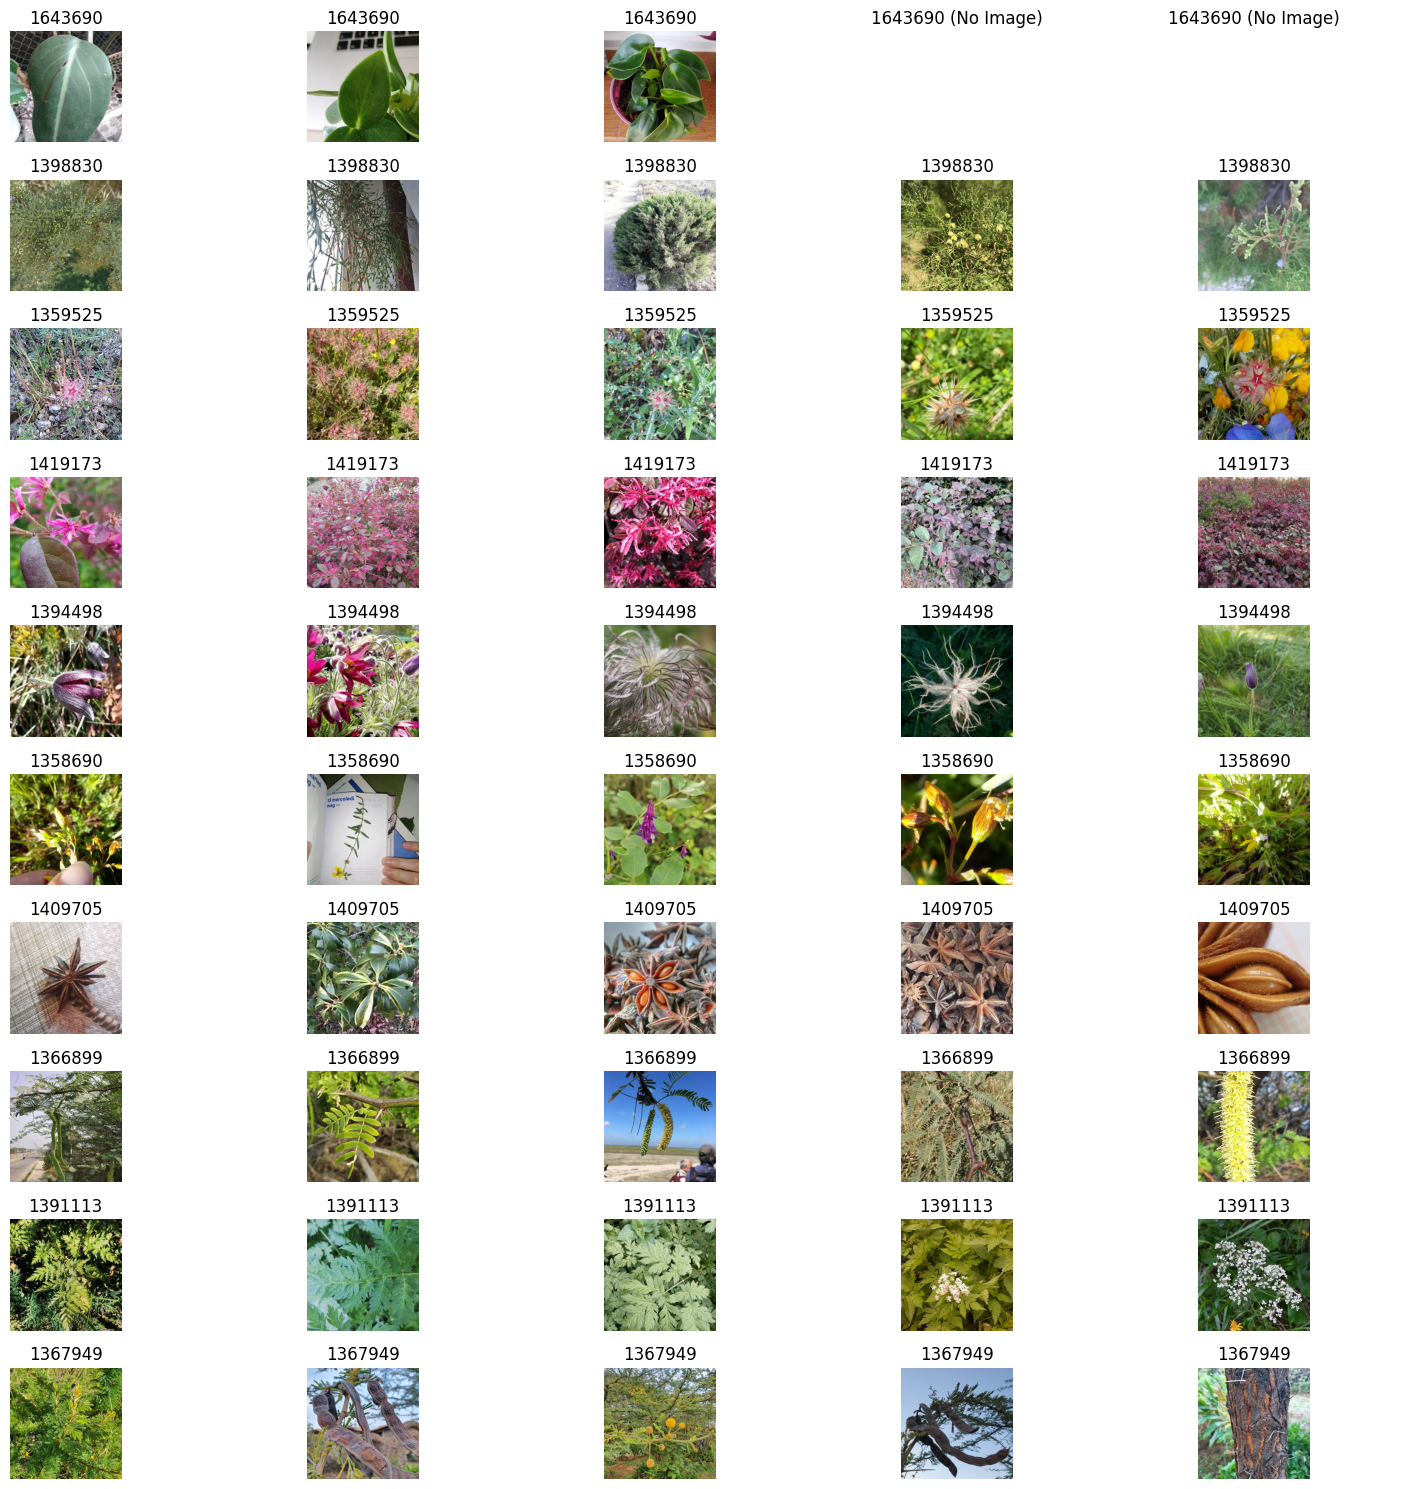

In [10]:
fig, axes = plt.subplots(10, 5, figsize=(15, 15))
axes = axes.ravel()

for i in range(50):
    plant = plant_folders[i // 5]
    img_files = list(train_path.glob(f'{plant}/*'))
    
    if len(img_files) > i % 5:
        img_path = img_files[i % 5]
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(plant)
    else:
        axes[i].axis('off')
        axes[i].set_title(f'{plant} (No Image)')

plt.tight_layout()
plt.show()

In [11]:
image_size = (180, 180)
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 243916 files belonging to 1081 classes.
Found 31118 files belonging to 1081 classes.
Found 31112 files belonging to 1081 classes.


In [12]:
class_names = test_dataset.class_names
num_classes = len(class_names)

In [13]:
#normalization
normalization_layer = layers.Rescaling(1./255)

In [14]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import layers, models

base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(180, 180, 3))


In [15]:
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal"),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomZoom(0.1),
#     layers.experimental.preprocessing.RandomContrast(0.1)
# ])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [16]:
model = tf.keras.Sequential([
    # Data augmentation layer
    layers.Input(shape=(180, 180, 3)),
    normalization_layer,
    data_augmentation,
    
    # Base model (DenseNet169)
    base_model,
    
    # Additional layers
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(num_classes, activation='softmax')
])

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Change the learning rate
optimizer.learning_rate.assign(0.0001)


AttributeError: 'Adam' object has no attribute 'lr'

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 5, 5, 1664)        12642880  
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 1664)       6656      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)             

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/densenet_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [ ]:
import warnings

warnings.filterwarnings('ignore')  # This suppresses all warnings


In [ ]:
#let's train!
epochs=3
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/3


7623/7623 [==============================] - 3579s 469ms/step - loss: 2.0480 - accuracy: 0.5800 - val_loss: 1.5827 - val_accuracy: 0.6539
Epoch 2/3
7623/7623 [==============================] - 3608s 473ms/step - loss: 1.2811 - accuracy: 0.6942 - val_loss: 1.4272 - val_accuracy: 0.6760
Epoch 3/3
7623/7623 [==============================] - 3616s 474ms/step - loss: 1.0715 - accuracy: 0.7293 - val_loss: 1.2902 - val_accuracy: 0.7034


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

973/973 [==============================] - 68s 70ms/step - loss: 1.2750 - accuracy: 0.7023
Test accuracy: 0.702
